In [1]:
import os
import random
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
base_context = 'fivethirtyeight'

def fast_hist(data, n=30, ax=None, figsize=(12, 4), title='', alpha=1, label='', new_figure=True):    
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        data.hist(bins=n, ax=ax, figsize=figsize, alpha=alpha, label=label)
        plt.title(title);
        
def fast_plot(data, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):    
    data = data.rolling(rolling).mean()    
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(data.index, data, alpha=alpha)
        plt.plot(data.index, data, linewidth=0.5, label=label)
        if title is not None:
            plt.title(title)
        
def display_series(data, name=' '):
    df = data.to_frame().T
    df.index = [name]
    display(df)

# Загрузка данных

In [3]:
train_features = pd.read_csv('data/train_features.csv', index_col='timestamp', parse_dates=True)
train_targets = pd.read_csv('data/train_targets.csv', index_col='timestamp', parse_dates=True)
test_features = pd.read_csv('data/test_features.csv', index_col='timestamp', parse_dates=True)
submission = pd.read_csv('data/sample_submission.csv', index_col='timestamp', parse_dates=True)
print('Train features shape:', train_features.shape)
print('Train targets shape:', train_targets.shape)
print('Test features shape:', test_features.shape)
print('Submission shape:', submission.shape)


targets = train_targets.columns
#train = pd.concat([train_features, test_features])

train = train_features
train = train.fillna(method='ffill')
train['B'] = train['B_rate'].cumsum()

train = pd.merge(train, train_targets, left_index=True, right_index=True, how='outer')
train = train['2020-01-01 04:30:00':]

Train features shape: (5808, 10)
Train targets shape: (5808, 4)
Test features shape: (3984, 10)
Submission shape: (3984, 4)


# Анализ

## Общая инфо

In [4]:
print(train_features.shape)
print(test_features.shape)
print(train_targets.shape)

(5808, 10)
(3984, 10)
(5808, 4)


In [5]:
display(train_features.tail())
display(train_targets.tail())

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
timestamp,,,,,,,,,,
2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367
2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575
2020-04-30 23:30:00,71.730325,0.265635,5.069165,36.602453,16.649167,24.150503,5.752792,4.997528,6.459137,74.327170


,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
timestamp,,,,
2020-04-30 21:30:00,4.816865,35.539156,16.269938,24.770377
2020-04-30 22:00:00,4.993286,36.067750,16.317757,24.729847
2020-04-30 22:30:00,5.101574,36.275040,16.295460,24.629889
2020-04-30 23:00:00,5.210675,36.872917,16.336359,24.438236
2020-04-30 23:30:00,5.136487,35.860326,16.101509,24.426845


## Расход

In [6]:
nas_df = pd.concat([train_features[['A_rate', 'B_rate']].isna().sum().to_frame().T,
                    test_features[['A_rate', 'B_rate']].isna().sum().to_frame().T])
nas_df.index = ['Nas in train', 'Nas in test']
display(nas_df)

,A_rate,B_rate
Nas in train,1,133
Nas in test,1142,5


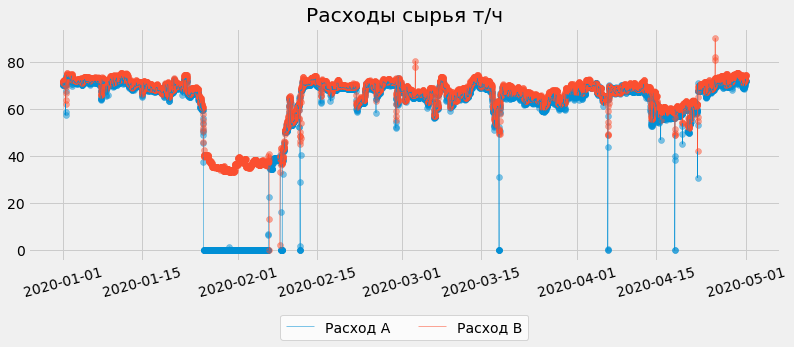

In [7]:
fast_plot(train_features['A_rate'], label='Расход A', title='Расходы сырья т/ч')
fast_plot(train_features['B_rate'], new_figure=False, label='Расход B')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

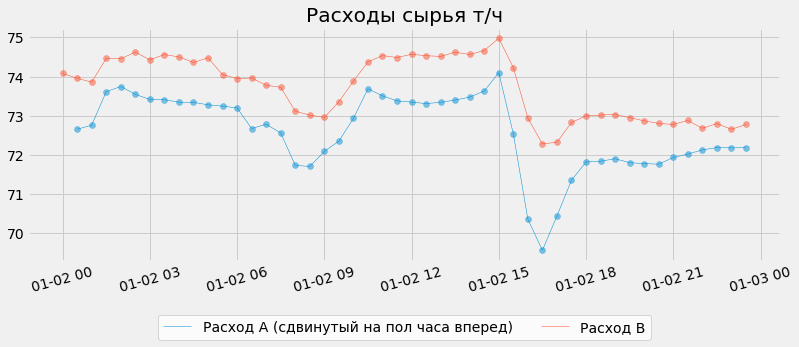

In [8]:
date1 = '2020-01-02'
date2 = '2020-01-02'
fast_plot(train_features['A_rate'][date1:date2].shift(1), rolling=1, label='Расход A (сдвинутый на пол часа вперед)',
          title='Расходы сырья т/ч')
fast_plot(train_features['B_rate'][date1:date2], new_figure=False, label='Расход B')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

## Компонентный состав

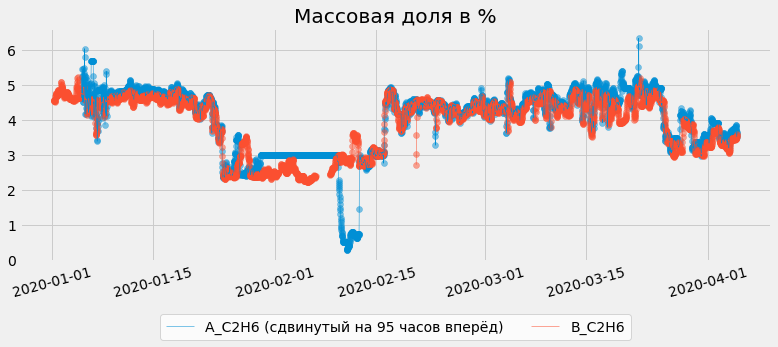

In [9]:
mask = train.index < '2020-04-05'
fast_plot(train['A_C2H6'][mask].shift(190), label='A_C2H6 (сдвинутый на 95 часов вперёд)',
          title='Массовая доля в %')
fast_plot(train['B_C2H6'][mask], new_figure=False, alpha=0.5, rolling=5, label='B_C2H6')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

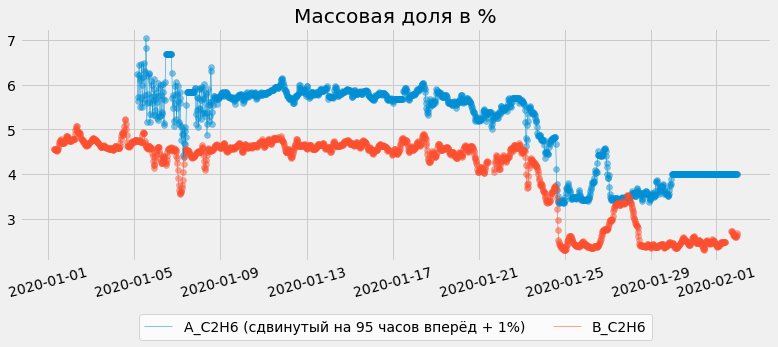

In [10]:
mask = train.index < '2020-02-02'
fast_plot(train['A_C2H6'][mask].shift(190) + 1, label='A_C2H6 (сдвинутый на 95 часов вперёд + 1%)',
          title='Массовая доля в %')
fast_plot(train['B_C2H6'][mask], new_figure=False, alpha=0.5, rolling=5, label='B_C2H6')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

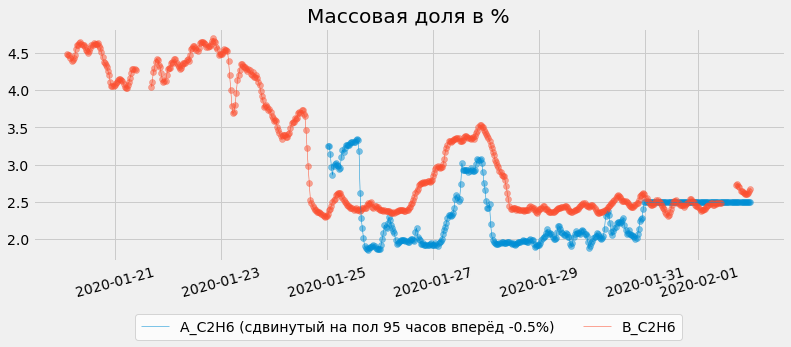

In [11]:
mask = (train.index > '2020-01-20') & (train.index < '2020-02-02')
fast_plot(train['A_C2H6'][mask].shift(240) - 0.5, label='A_C2H6 (сдвинутый на пол 95 часов вперёд -0.5%)',
          title='Массовая доля в %')
fast_plot(train['B_C2H6'][mask], new_figure=False, alpha=0.5, rolling=5, label='B_C2H6')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

> __Идет изменение сдвига и некоторое сжатие по времени__

## Поиск сдвига по B

In [12]:
def get_value_by_flow(data, feature, cut_feature, cut):
    mask = data[cut_feature] < cut
    if mask.sum() > 0:
        return data[feature][mask][-1]
    else:
        return np.NaN   

In [13]:
%%time
shifts = [x * 1000 + 0 for x in range(0, 21)]

for shift in shifts:
    train[f'shift_{shift}'] = np.NaN
    
    for i in range(train.shape[0]):
        train[f'shift_{shift}'].iloc[i] =  get_value_by_flow(train, 'A_C2H6', 'B', train.iloc[i]['B'] - shift)

Wall time: 3min 2s


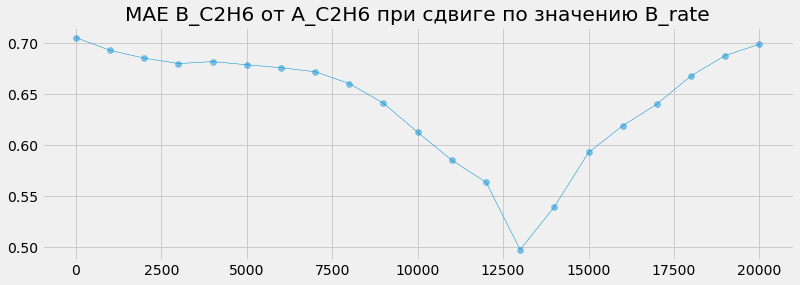

,errors
13000,0.497278
14000,0.539405
12000,0.563589
11000,0.585110
15000,0.592711


In [14]:
shifted_features = [x for x in train.columns if 'shift' in x]

df = pd.DataFrame(index=shifted_features)
df['errors'] = 0
df = df.sort_index()
df.head()

for feature in shifted_features:
    df['errors'].loc[feature] = (train['B_C2H6'] - train[feature]).abs().mean()

df.index = [x.replace('shift_', '') for x in df.index]
df.index = df.index.to_series().astype(int)
df = df.sort_index()

fast_plot(df['errors'], title='MAE B_C2H6 от A_C2H6 при сдвиге по значению B_rate')
plt.show()

df.sort_values('errors').head()

In [15]:
%%time

# Удаление старых сдвигов
train = train[[x for x in train.columns if 'shift' not in x ]]

# Уточнение сдвигов
shifts = [x * 50 + 12500 for x in range(0, 31)]

for shift in shifts:
    train[f'shift_{shift}'] = np.NaN
    
    for i in range(train.shape[0]):  # range(10):#
        train[f'shift_{shift}'].iloc[i] =  get_value_by_flow(train, 'A_C2H6', 'B', train.iloc[i]['B'] - shift)

Wall time: 4min 26s


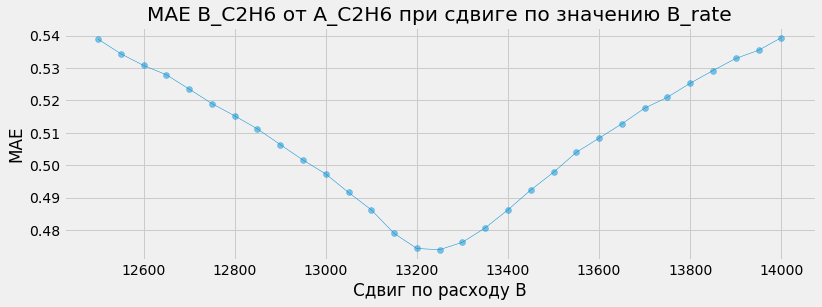

,errors
13250,0.473899
13200,0.474268
13300,0.476199
13150,0.478938
13350,0.480637


In [16]:
shifted_features = [x for x in train.columns if 'shift' in x]

df = pd.DataFrame(index=shifted_features)
df['errors'] = 0
df = df.sort_index()
df.head()

for feature in shifted_features:
    df['errors'].loc[feature] = (train['B_C2H6'] - train[feature]).abs().mean()

df.index = [x.replace('shift_', '') for x in df.index]
df.index = df.index.to_series().astype(int)
df = df.sort_index()

fast_plot(df['errors'], title='MAE B_C2H6 от A_C2H6 при сдвиге по значению B_rate')
plt.xlabel('Сдвиг по расходу B')
plt.ylabel('MAE')
plt.show()

df.sort_values('errors').head()

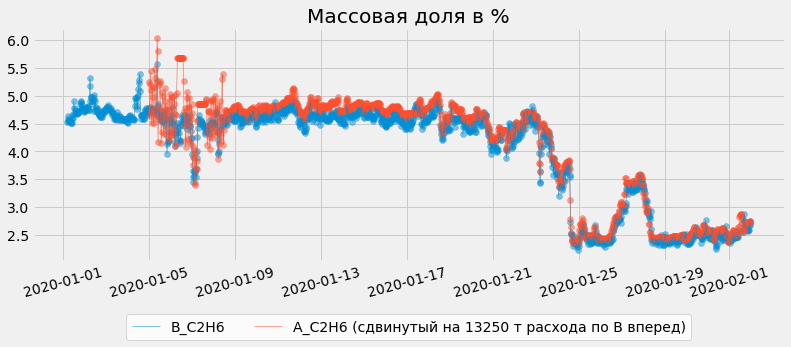

In [17]:
mask = train.index < '2020-02-02'
fast_plot(train['B_C2H6'][mask], title='Массовая доля в %', label='B_C2H6')
fast_plot(train['shift_13250'][mask], new_figure=False, label='A_C2H6 (сдвинутый на 13250 т расхода по B вперед)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)
plt.xticks(rotation=15);

## Выбор периода обучения

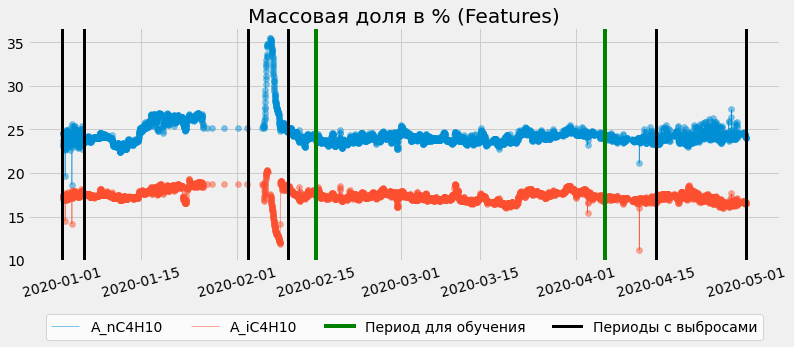

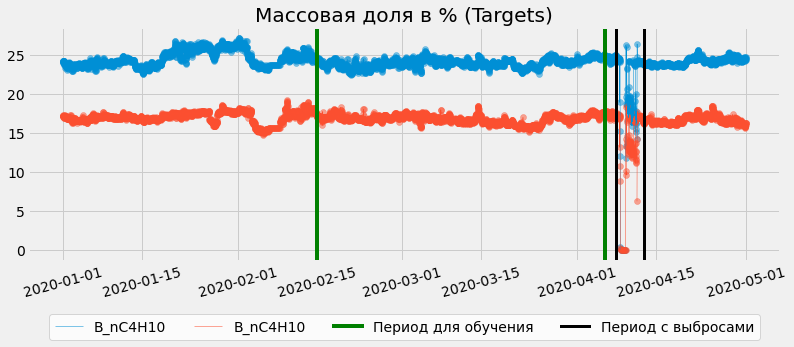

In [18]:
fast_plot(train_features['A_nC4H10'], title='Массовая доля в % (Features)', label='A_nC4H10')
fast_plot(train_features['A_iC4H10'], new_figure=False, label='A_iC4H10')
plt.axvline(pd.to_datetime('2020-02-15'), color='green', label = 'Период для обучения', lw=4)
plt.axvline(pd.to_datetime('2020-04-06'), color='green', lw=4)
plt.axvline(pd.to_datetime('2020-01-01'), color='black', label = 'Периоды с выбросами', lw=3)
plt.axvline(pd.to_datetime('2020-01-05'), color='black', lw=3)
plt.axvline(pd.to_datetime('2020-02-03'), color='black', lw=3)
plt.axvline(pd.to_datetime('2020-02-10'), color='black', lw=3)
plt.axvline(pd.to_datetime('2020-04-15'), color='black', lw=3)
plt.axvline(pd.to_datetime('2020-05-01'), color='black', lw=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

fast_plot(train_targets['B_nC4H10'], title='Массовая доля в % (Targets)', label='B_nC4H10')
fast_plot(train_targets['B_iC4H10'], new_figure=False, label='B_nC4H10')
plt.axvline(pd.to_datetime('2020-02-15'), color='green', label = 'Период для обучения', lw=4)
plt.axvline(pd.to_datetime('2020-04-06'), color='green', lw=4)
plt.axvline(pd.to_datetime('2020-04-08'), color='black', label = 'Период с выбросами', lw=3)
plt.axvline(pd.to_datetime('2020-04-13'), color='black', lw=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

# Базовая модель


In [19]:
def metric_value(y, y_pred):
    return ((y - y_pred)/y).abs().mean()

def mean_metric(y_data, pred_data):
    summary = []
    for col in y_data:
        summary.append(metric_value(y_data[col], pred_data[col]))
        
    return summary

In [20]:
def predict(data, feature, cut_feature, shift=13250):
    data = data.copy()
    data['Pred'] = np.NaN
    
    for i in range(data.shape[0]): 
        data['Pred'].iloc[i] =  get_value_by_flow(data, feature, cut_feature, data.iloc[i][cut_feature] - shift)
        
    return data['Pred']

In [21]:
targets = train_targets.columns

train_mask = ((train.index > '2020-02-15') & (train.index < '2020-03-19') & (train[targets].sum(axis=1) > 0)) | \
    ((train.index > '2020-03-22') & (train.index < '2020-04-06') & (train[targets].sum(axis=1) > 0))

train_targets_mask = ((train_targets.index > '2020-02-15') & (train_targets.index < '2020-03-19') &
                      (train_targets.sum(axis=1) > 0)) | \
                     ((train_targets.index > '2020-03-22') & (train_targets.index < '2020-04-06') & 
                      (train_targets.sum(axis=1) > 0)) 

## Первая посылка


In [22]:
%%time
cut_feature = 'B'

train['B_C2H6'] = predict(train, 'A_C2H6', cut_feature, shift=13250)
train['B_C3H8'] = predict(train, 'A_C3H8', cut_feature, shift=13250)
train['B_iC4H10'] = predict(train, 'A_iC4H10', cut_feature, shift=13250)
train['B_nC4H10'] = predict(train, 'A_nC4H10', cut_feature, shift=13250)

Wall time: 32.5 s


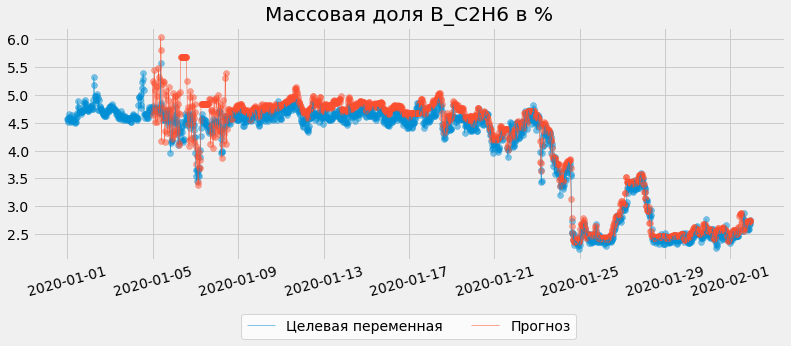

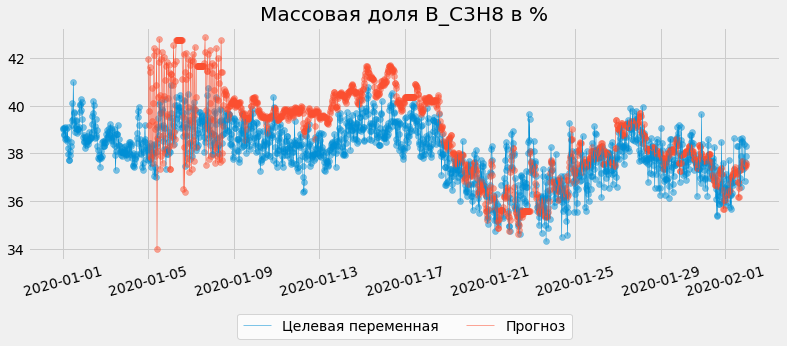

In [23]:
mask = train.index < '2020-02-02'
mask_targets = train_targets.index < '2020-02-02'
fast_plot(train_targets['B_C2H6'][mask_targets], title='Массовая доля B_C2H6 в %', label='Целевая переменная')
fast_plot(train['B_C2H6'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

fast_plot(train_targets['B_C3H8'][mask_targets], title='Массовая доля B_C3H8 в %', label='Целевая переменная')
fast_plot(train['B_C3H8'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

In [24]:
print(np.round(np.mean(mean_metric(train_targets[train_targets_mask], train[train_mask][targets])) * 100, 3))

2.798


## Вторая посылка

In [25]:
%%time
cut_feature = 'B'

train['B_C2H6'] = predict(train, 'A_C2H6', cut_feature, shift=13250)
train['B_C3H8'] = predict(train, 'A_C3H8', cut_feature, shift=13250)
train['B_iC4H10'] = predict(train, 'A_iC4H10', cut_feature, shift=13250)
train['B_nC4H10'] = predict(train, 'A_nC4H10', cut_feature, shift=13250)

Wall time: 33.1 s


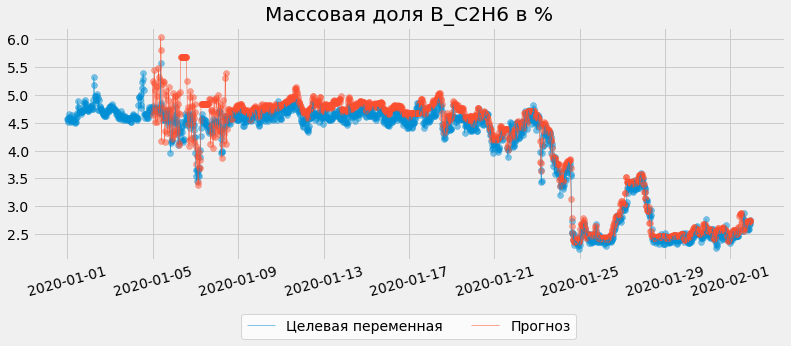

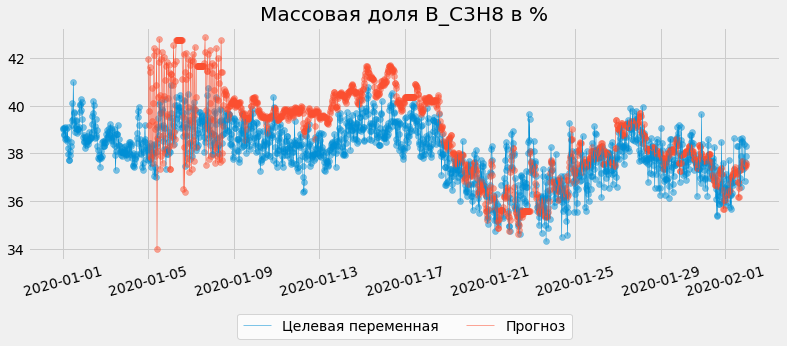

In [26]:
mask = train.index < '2020-02-02'
mask_targets = train_targets.index < '2020-02-02'
fast_plot(train_targets['B_C2H6'][mask_targets], title='Массовая доля B_C2H6 в %', label='Целевая переменная')
fast_plot(train['B_C2H6'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

fast_plot(train_targets['B_C3H8'][mask_targets], title='Массовая доля B_C3H8 в %', label='Целевая переменная')
fast_plot(train['B_C3H8'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

In [27]:
def scale_predictions(data, rates):
    data = data.copy()
    for column in rates.columns:
        data[column] *= rates[column].values[0]
    return data

In [28]:
rate = (train_targets[train_targets_mask] / train[train_mask][targets]).describe().loc['50%'].to_frame().T
display(rate)

train_scaled = scale_predictions(train[targets], rate)
print('MAPE без масштабирования:', np.round(np.mean(mean_metric(train_targets[train_targets_mask], train[train_mask][targets])) * 100, 3))
print('MAPE c масштабированием:',np.round(np.mean(mean_metric(train_targets[train_targets_mask], train_scaled[train_mask][targets])) * 100, 3))

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
50%,0.966382,0.970978,0.973655,0.999453


MAPE без масштабирования: 2.798
MAPE c масштабированием: 1.665


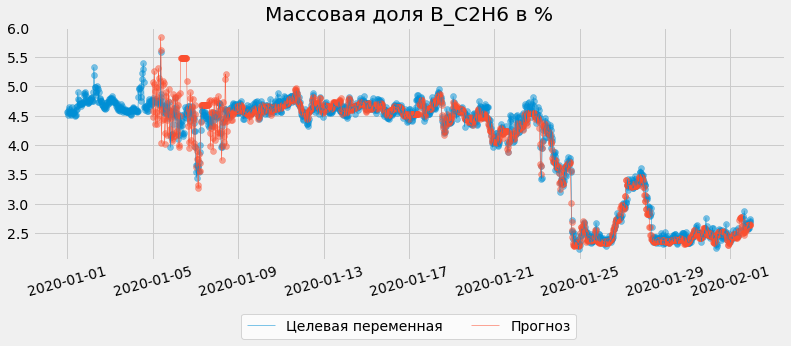

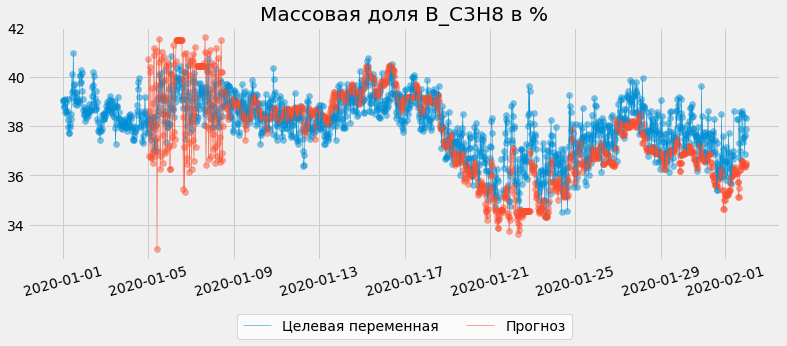

In [29]:
mask = train_scaled.index < '2020-02-02'
mask_targets = train_targets.index < '2020-02-02'
fast_plot(train_targets['B_C2H6'][mask_targets], title='Массовая доля B_C2H6 в %', label='Целевая переменная')
fast_plot(train_scaled['B_C2H6'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

fast_plot(train_targets['B_C3H8'][mask_targets], title='Массовая доля B_C3H8 в %', label='Целевая переменная')
fast_plot(train_scaled['B_C3H8'][mask], new_figure=False, label='Прогноз')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=14)
plt.xticks(rotation=15);

# Оптимизация окна сдвига

In [30]:
def get_value_by_flow(data, feature, cut_feature, low, high):
    mask = (data[cut_feature] > low) & (data[cut_feature] < high)
    if mask.sum() > 0:
        result = (data[feature][mask] * data['B_rate'][mask]).sum() / data['B_rate'][mask].sum()
        return result
    else:
        return np.NaN

In [31]:
def predict(data, feature, cut_feature, low=13320, high=13180):
    data = data.copy()
    data['Pred'] = np.NaN
    
    for i in range(data.shape[0]): 
        data['Pred'].iloc[i] =  get_value_by_flow(data, feature, cut_feature, 
                                                  data.iloc[i][cut_feature] - low,
                                                  data.iloc[i][cut_feature] - high)
        
    return data['Pred']

### A_iC4H10

In [32]:
lows = np.linspace(13600, 13200, 11).astype(int)
highs = np.linspace(13100, 12900, 6).astype(int)
print(lows)
print(highs)

[13600 13560 13520 13480 13440 13400 13360 13320 13280 13240 13200]
[13100 13060 13020 12980 12940 12900]


In [33]:
%%time
df_B_iC4H10 = pd.DataFrame(index=lows, columns=highs)
cut_feature = 'B'

for low in lows:
    for high in highs:
        if high < low:
            x = predict(train, 'A_iC4H10', cut_feature, low=low, high=high)
            x_rate = (train_targets['B_iC4H10'][train_targets_mask] / x[train_mask]).describe().loc['50%']
            x *= x_rate
            
            error = np.mean(metric_value(train_targets['B_iC4H10'][train_targets_mask], x[train_mask]))
            print('Low:', low, 'high:', high, 'error:', np.round(error, 5))
            df_B_iC4H10.loc[low, high] = error  

Low: 13600 high: 13100 error: 0.01015
Low: 13600 high: 13060 error: 0.0101
Low: 13600 high: 13020 error: 0.01012
Low: 13600 high: 12980 error: 0.01014
Low: 13600 high: 12940 error: 0.01016
Low: 13600 high: 12900 error: 0.01024
Low: 13560 high: 13100 error: 0.01005
Low: 13560 high: 13060 error: 0.01001
Low: 13560 high: 13020 error: 0.01004
Low: 13560 high: 12980 error: 0.01008
Low: 13560 high: 12940 error: 0.01012
Low: 13560 high: 12900 error: 0.01021
Low: 13520 high: 13100 error: 0.00993
Low: 13520 high: 13060 error: 0.00992
Low: 13520 high: 13020 error: 0.00996
Low: 13520 high: 12980 error: 0.01001
Low: 13520 high: 12940 error: 0.01008
Low: 13520 high: 12900 error: 0.01019
Low: 13480 high: 13100 error: 0.00984
Low: 13480 high: 13060 error: 0.00985
Low: 13480 high: 13020 error: 0.00991
Low: 13480 high: 12980 error: 0.00999
Low: 13480 high: 12940 error: 0.01006
Low: 13480 high: 12900 error: 0.0102
Low: 13440 high: 13100 error: 0.00977
Low: 13440 high: 13060 error: 0.00981
Low: 13440 hig

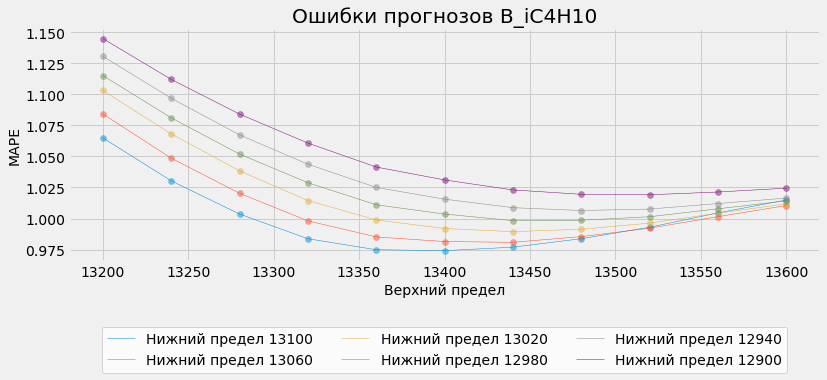

,13400,13360,13440,13320,13480
13100,0.97406,0.97482,0.976883,0.983688,0.983704


,13440,13400,13360,13480,13520
13060,0.980796,0.981424,0.985144,0.985394,0.992196


,13440,13480,13400,13520,13360
13020,0.989387,0.991366,0.99193,0.996245,0.998859


,13440,13480,13520,13400,13560
12980,0.998288,0.998593,1.00141,1.00358,1.00782


,13480,13520,13440,13560,13400
12940,1.00644,1.00762,1.00873,1.01205,1.01559


,13520,13480,13560,13440,13600
12900,1.01913,1.01951,1.02135,1.02304,1.02445


In [34]:
x1 = 13100
x2 = 13060
x3 = 13020
x4 = 12980
x5 = 12940
x6 = 12900

fast_plot(df_B_iC4H10[x1] * 100, label=f'Нижний предел {x1}', title='Ошибки прогнозов B_iC4H10')
fast_plot(df_B_iC4H10[x2] * 100, label=f'Нижний предел {x2}', new_figure=False)
fast_plot(df_B_iC4H10[x3] * 100, label=f'Нижний предел {x3}', new_figure=False)
fast_plot(df_B_iC4H10[x4] * 100, label=f'Нижний предел {x4}', new_figure=False)
fast_plot(df_B_iC4H10[x5] * 100, label=f'Нижний предел {x5}', new_figure=False)
fast_plot(df_B_iC4H10[x6] * 100, label=f'Нижний предел {x6}', new_figure=False)
plt.xlabel('Верхний предел', fontsize=14)
plt.ylabel('MAPE', fontsize=14)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.25), fontsize=14)
plt.show()

display(df_B_iC4H10.sort_values(x1)[x1].to_frame().head().T * 100)
display(df_B_iC4H10.sort_values(x2)[x2].to_frame().head().T * 100)
display(df_B_iC4H10.sort_values(x3)[x3].to_frame().head().T * 100)
display(df_B_iC4H10.sort_values(x4)[x4].to_frame().head().T * 100)
display(df_B_iC4H10.sort_values(x5)[x5].to_frame().head().T * 100)
display(df_B_iC4H10.sort_values(x6)[x6].to_frame().head().T * 100)

__Для каждой прогнозируемой компоненты были подобраны свои сдвиги__